In [4]:
using Distributed

In [2]:
workers()

1-element Vector{Int64}:
 1

In [3]:
addprocs(3)
;

In [4]:
nworkers()

3

In [5]:
@everywhere using FastaIO
@everywhere using MultivariateStats
@everywhere using LinearAlgebra
@everywhere using DelimitedFiles
@everywhere using StatsBase
@everywhere using DCAUtils
@everywhere using Plots

@everywhere using Random
@everywhere using Statistics
@everywhere using KitMSA

In [6]:
@everywhere include("../src/Basic_code/read_write.jl")
@everywhere include("../src/Basic_code/energy.jl")
@everywhere include("../src/Basic_code/msa_tools.jl")
@everywhere include("../src/Basic_code/extra_tools.jl")

In [7]:
function sweep1(ref_MSA, MSAs, steps, file)
    
    f_ref = first_stat(ref_MSA)
    freqs = [first_stat(matrix) for matrix in MSAs]
    
    r_spearman = [corspearman(f_ref, f) for f in freqs]
    r_pearson = [cor(f_ref, f) for f in freqs]
    
    scatter(steps, r_spearman, xscale=:log10, label ="spearman", legend=:bottomright)
    scatter!(steps, r_pearson, label ="pearson ")
    savefig(file)
    
end

function amino_seq2dna_seq(seq)
    seq_dna=[]
    for a in seq
        push!(seq_dna, sample(amino2cod[a]))
    end
    return seq_dna
end

function dna_seq2amino_seq(seq_dna)
    new = []
    for a in seq_dna
        push!(new, cod2amino[a])
    end
    return new
end

function pairwise_hamming(msa::Array{Int8,2})
    num_seqs = size(msa, 1)
    pairwise_distances = Array{Int,1}(undef, num_seqs*(num_seqs-1)÷2)
    idx = 1
    for i in 1:num_seqs-1
        for j in i+1:num_seqs
            dist = KitMSA.my_hamming(msa[i,:], msa[j,:])
            pairwise_distances[idx] = dist
            idx += 1
        end
    end
    return pairwise_distances
end


function eliminate(msa, tresh, idx)
    L = length(msa[idx,:])
    trimmed_msa = []
    for i in 1:length(msa[:,1])
        d = KitMSA.my_hamming(msa[idx,:], msa[i,:])
        if  d > L*tresh
            push!(trimmed_msa, msa[i,:])
        end
    end
    push!(trimmed_msa, msa[idx,:])
    return hcat(trimmed_msa...)'
end


function reweighting(msa, tresh)
    final_msa =[]
    new_msa = deepcopy(msa)
    a = 0
    for i in 1:20000
        new_msa = eliminate(new_msa, tresh, 1)
    end    
    println(length(new_msa[:,1]))
    return new_msa
end

function project_pca(filename, label1, label2, eigenv, pc_ref, one_non_ref)
    pc_proj = eigenv[:, [end, end-1]]'*one_non_ref'
    scatter(pc_nat[1,:], pc_nat[2,:], alpha = 0.25, label= label1, legend=:topright)
    scatter!(pc_proj[1,:], pc_proj[2,:], alpha = 0.25,color=:red, label= label2 )
    savefig(filename)
end

function plot_pca(pc_ref, eigenv, matrices, filepath)
    
    for i in 1:length(matrices)
        one_hot_proj = one_hot(matrices[i])
        project_pca(joinpath(filepath, "pca$(i).png"), "nat", "sil step $(i)", eigenv, pc_ref, one_hot_proj)
        println(i)
    end
end

plot_pca (generic function with 1 method)

In [8]:
@everywhere function Delta_energy(h::Array{Float64,2}, J::Array{Float64,4}, 
        S::Array{<:Integer,1}, ref::Array{<:Integer, 1})
    q, N = size(h)
    E = 0.0
    
   
    index_v = collect(1:N)
    common = (S .== ref)
    idx = findfirst(isequal(false), common)
    common = index_v[common]
    #println(idx)
    #println(common)
    E -= (h[S[idx],idx] - h[ref[idx],idx])
    @fastmath for j = 1:N
        if j > idx
            @inbounds  E -= (J[S[j],S[idx],j,idx] - J[ref[j],ref[idx],j,idx] )
        end
    end
    
    @fastmath for i in common
        if idx > i
            @inbounds  E -= (J[S[idx],S[i],idx,i] - J[ref[idx],ref[i],idx,i] )
        end
    end
    
    return E
end


In [9]:
@everywhere function get_accessible_nucleo_muts_metro_DNA_det_bal(old_cod)
    if old_cod .== "---"
        amino_list = [i for i in 1:21]
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        codon_list = filter!(aa->aa != old_cod, codon_list)
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    end
    
    old_codon = [string(old_cod[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 12)
    
    for i in 1:3
        new_codon = deepcopy(old_codon)
        for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
            new_codon[i] = nucl
            codon_list[(i-1)*4 + j] = join(new_codon)
        end
    end
    
    push!(codon_list, "---")
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	amino_list = unique!(filter!(aa->aa != 21, amino_list))

    #codon_list = filter!(aa->aa != "TAA", codon_list)
    #codon_list = filter!(aa->aa != "TAG", codon_list)
    #codon_list = filter!(aa->aa != "TGA", codon_list)
    codon_list = filter!(aa->aa != old_cod, codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end


@everywhere function get_accessible_nucleo_for_del_ins(old_cod)

    if old_cod .== "---"
        amino_list = [i for i in 0:20]
        amino_list[1] = 21
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        #push!(codon_list, old_cod )
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    else
        codon_list = ["---"]
        push!(codon_list, old_cod)
        amino_list = get.(Ref(cod2amino), codon_list, 0)
        #println(amino_list)
        return amino_list, codon_list
    end
end
   

In [10]:
@everywhere mutable struct SeqToEvolve
    Amino   :: Array{Int64}
    DNA :: Array{AbstractString}
end

@everywhere function get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos::Integer)
    old_codon = [string(old_codon[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 4)
	new_codon = deepcopy(old_codon)
	for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
		new_codon[nucleo_pos] = nucl
		codon_list[j] = join(new_codon)
	end
    
    codon_list = filter!(aa->aa != "TAA", codon_list)
    codon_list = filter!(aa->aa != "TAG", codon_list)
    codon_list = filter!(aa->aa != "TGA", codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end

@everywhere function sum_couplings_inbounds(mutated_seq, q_k, k, J::Array{Float64,4}, N)
    result = 0
    @inbounds for i in 1:N
        result += J[mutated_seq[i], q_k ,i, k]
    end
    return result
end 

@everywhere function nucleo_cond_proba_DNA_gibbs(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
    #println(q)
    #println(codon_list)
	@inbounds for (index, codon_k) in enumerate(codon_list)
        #println(index)
        q_k = q[index]
        #println(q_k)
        log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
        log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
		prob[index] = exp(log_proba/T)
	end
	return normalize(prob,1)
end



@everywhere function log_p(mutated_seq, q_k, k, J::Array{Float64,4}, N::Integer,T=1)
    
    log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
    log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
    return log_proba  
end


@everywhere function square_array(arr)
    squares = Dict()
    result = similar(arr)
    for i in 1:length(arr)
        if haskey(squares, arr[i])
            result[i] = squares[arr[i]]
            println("not computed")
        else
            square = arr[i]^2
            squares[arr[i]] = square
            result[i] = square
            println("computed")
        end
    end
    return result
end


@everywhere function nucleo_cond_proba_DNA_gibbs_new(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
        
    d = Dict{Int64, Float64}()
    
	@inbounds for (index, q_k) in enumerate(q)
            
        if haskey(d, q_k)
            log_proba = d[q_k]
            #println("not computed")
        else
            log_proba = log_p(mutated_seq, q_k, k, J, N, T)
            d[q_k] = log_proba
            #println("computed")
        end
		prob[index] = exp(log_proba/T)
	end
        
	return normalize(prob,1)
end

In [24]:
@everywhere function del_ins_codon_sampling(arr)
    n = length(arr)
    beta = 1/64
    alpha = 1-64*beta
    gamma = 1-beta
    if n==2
        probabilities = [beta, gamma]
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    else 
        probabilities = fill(beta, n)
        probabilities[1] = alpha
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    end
end
    
#arr = [5,10]
#sampled_elements = [del_ins_codon_sampling(arr) for i in 1:6400]
#histogram(sampled_elements)
    
@everywhere function gibbs_step(mutated_seq, non_gapped_pos, h, J, N, T)
    #println("doing gibbs step")
    pos_mut = rand(non_gapped_pos)

	old_codon = mutated_seq.DNA[pos_mut]
    #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
        
    nucleo_pos = rand(1:3)
        
    amino_list, codon_list = get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos)
        
    if length(unique(amino_list)) == 1
        new_codon = rand(codon_list)
    else
        new_codon = sample(codon_list, ProbabilityWeights(nucleo_cond_proba_DNA_gibbs_new(pos_mut, amino_list, codon_list, mutated_seq.Amino, h, J, N, T)))
    end
            
    aa = cod2amino[new_codon]
        
	mutated_seq.DNA[pos_mut] = new_codon	
	mutated_seq.Amino[pos_mut] = aa
    
    return mutated_seq
end     


@everywhere function metro_del_ins_step(mutated_seq, non_gapped_pos, h, J, N, T)
    #println("doing metropolis insertion/deletion step")
        
    pos_mut = rand(1:length(mutated_seq.Amino))

	old_codon = mutated_seq.DNA[pos_mut]
    old_amino = mutated_seq.Amino[pos_mut]
    #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
    amino_list, codon_list = get_accessible_nucleo_for_del_ins(old_codon)
    #println("Accessible codons (step $steps ) : $(codon_list)")
        
    new_codon = del_ins_codon_sampling(codon_list)
    
    #println("Proposed codon (step $steps ) : $(new_codon)")
    
    if new_codon == "TAA"  ||  new_codon == "TAG"   || new_codon == "TGA"  || new_codon == old_codon
        
    else
        new_amino = cod2amino[new_codon]  
        new_sequence = deepcopy(mutated_seq.Amino)
        new_sequence[pos_mut] = new_amino
        deltaE = Delta_energy(h, J, new_sequence, mutated_seq.Amino)
        accept_proba = (length(amino2cod[old_amino])/length(amino2cod[new_amino]))*exp(-(1/T)*deltaE)
        if rand() < accept_proba
            aa = cod2amino[new_codon]
            mutated_seq.DNA[pos_mut] = new_codon	
            mutated_seq.Amino[pos_mut] = aa
            #acceptance += 1
        end
    end
    return mutated_seq
end


@everywhere function parallel_evol_seq_fix_steps_DNA_mixed_nucleo(ham, p, dir_amino::AbstractString,
                    sampler_type::AbstractString, wt_name::AbstractString, ref_seq, 
                    MC_steps::Integer, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer, chain_num::Integer, T = 1)
    
    
    file_path_amino = joinpath(dir_amino, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
    
    #println(length(ref_seq))
    mutated_seq = deepcopy(ref_seq[chain_num])
                
    
    
    
    FastaWriter(file_path_amino, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | WT sequence | T = $(T)", vec2string(mutated_seq.Amino))   
    end
                
    wt = deepcopy(mutated_seq.Amino)
    max_ham = Int.(round(ham * length(wt)))
     # Create an array of 100 positions, each containing an empty array
    proteins = Vector{Vector{Vector{Int}}}(undef, max_ham)
    
    sel_proteins = []

    # Loop to initialize each empty array
    for i in 1:max_ham
        proteins[i] = Float64[]
    end 
    
    starting_seq = ref_seq[chain_num].Amino
      
    
    #target = [i/100 for i in 1:70]
    target = [i for i in 1:max_ham]
    wind = 0.005
                
    @inbounds for steps in 1:MC_steps
        non_gapped_pos = [pos for (pos, amino) in enumerate(mutated_seq.Amino) if amino != 21]
        if rand()<(1-p)
            mutated_seq = gibbs_step(mutated_seq, non_gapped_pos, h, J, N, T)
        else
            mutated_seq = metro_del_ins_step(mutated_seq, non_gapped_pos, h, J, N, T)
        end  
        
        d = KitMSA.my_hamming(ref_seq[chain_num].Amino, mutated_seq.Amino)
        
     
        for i in 1:max_ham
            
            if  d == target[i] 
                # Check if mutated_seq.Amino is different from all other sequences in proteins[i]
                is_different = all(seq -> seq != mutated_seq.Amino, proteins[i])

                if is_different
                    t = target[i]
                    #println("saving $chain_num at diverg $d, in cat $i, at step $steps")
                    sseq = deepcopy(mutated_seq.Amino)
                    push!(proteins[i], sseq)
                end                
            end
        end
        
        if steps == MC_steps
            for i in 1:max_ham
                if !isempty(proteins[i])
                    arr = proteins[i][1]
                    #println(arr)     
                    push!(sel_proteins, arr) 
                end
            end    
        end
    end
                      
    sel_proteins = hcat(sel_proteins...)'
    lung = length(sel_proteins[:,1])
    
    #println(count_muts_msa(sel_proteins, ref_seq[chain_num].Amino)[end])
    
    for i in 1:length(sel_proteins[:,1])
        #println(energy(h, J, sel_proteins[i,:]))
    
        FastaWriter(file_path_amino, "a") do file
            writeentry(file, "sampler: $sampler_type | original wt: $wt_name | T = $(T)", vec2string(sel_proteins[i,:]))   
        end
            
    end       
end

In [12]:
@everywhere function sample_codons(arr)
    n = length(arr)
    probabilities = fill(7/64, n)
    probabilities[end] = 1/64
    index = sample(1:n, Weights(probabilities))
    return arr[index]
end

#arr = [1, 2, 3, 4,5,6,7,8,9,10]

#sampled_elements = [sample_codons(arr) for i in 1:640000]

#histogram(sampled_elements, bins = 10)


In [27]:
PATH_PAR_beta = "../model_parameters/Parameters_conv_Matteo_pc.dat"
PATH_PAR_dbd = "../model_parameters/Parameters_conv_Thr-PCD40.dat"

"../model_parameters/Parameters_conv_Thr-PCD40.dat"

In [14]:
#load fields
h, J = KitMSA.extract_params(PATH_PAR_beta;q=21)
maximum(J)

1.199017

In [28]:
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)

1.959042

In [16]:

#define paths
path_wt_tem = "../alignments/refs/wt_DNA/TEM1_pfam_DNA.fasta"
path_wt_pse = "../alignments/refs/wt_DNA/PSE1_pfam_DNA.fasta"

#load wt
wt_tem = join(readdlm(path_wt_tem, skipstart = 1))
wt_pse = join(readdlm(path_wt_pse, skipstart = 1))


#transform wt_dna in amino
L_tem = Int64(length(wt_tem)/3)
tem_DNA_seq = [wt_tem[((i-1)*3 +1):(i*3)] for i in 1:L_tem]
tem_amino_seq = [cod2amino[codon] for codon in tem_DNA_seq]
seed_seq_tem = SeqToEvolve(tem_amino_seq, tem_DNA_seq)

L_pse = Int64(length(wt_pse)/3)
pse_DNA_seq = [wt_pse[((i-1)*3 +1):(i*3)] for i in 1:L_pse]
pse_amino_seq = [cod2amino[codon] for codon in pse_DNA_seq]
seed_seq_pse = SeqToEvolve(pse_amino_seq, pse_DNA_seq)
;

In [17]:
thornton_wt = Int8.(readdlm("../../wt_thornton", '\t')[:])
;

## Parallel Run

In [16]:
#nat_MSA = Int8.(fasta2matrix("../alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"))
nat_MSA = Int8.(fasta2matrix("../alignments/natural/DBD_alignment.uniref90.cov80.a2m"))
;

In [28]:
#steps = 256 #pse
#steps = 220 #tem
steps = 1500
ham = 0.40

#T = 1.33 #pse experiment
#T = 1.14 #tem experiment
T = 1.0 #natural
#sampler_type = "gibbs"
#sampler_type = "metro"
sampler_type = "mixed"
#nseq = 1:34431 #tem
#nseq = 1:456871 #pse
nseq = 1:1000
#wt_name = "dbd"
#wt_name = "pse"
#wt_name = "tem"
wt_name = "thornton_leaf"
N = length(nat_MSA[1,:])
#c = filter_alignment(nseq[end], nat_MSA)
#seed_seq = [SeqToEvolve(c[i,:], amino_seq2dna_seq(c[i,:])) for i in 1:length(c[:,1])]
#seed_seq = [SeqToEvolve(nat_MSA[100,:] , amino_seq2dna_seq(nat_MSA[100,:])) for i in 1:nseq[end]] #dbd
#dbd_sample = "CKVCSNQSNGYNFDVMTCVSCGAFFRRALVNPKNLICLRKNSCSIIYENRRSCSRCRLRKCFSVGMKKTT------"
#dbd_sample_AA = [letter2num(val) for val in dbd_sample]
#seed_seq = [SeqToEvolve(dbd_sample_AA , amino_seq2dna_seq(dbd_sample_AA)) 
    #for i in 1:nseq[end]] #dbd
#pse
"""
beta_sample_AA = [21, 21, 12, 6, 4, 20, 19, 3, 20, 12, 6, 12, 14, 15, 5, 13, 10, 17, 16, 
    17, 5, 9, 17, 8, 1, 2, 1, 9, 10, 10, 20, 3, 1, 4, 14, 6, 9, 18, 12, 13, 12, 16, 17,
    18, 4, 8, 9, 9, 1, 3, 10, 18, 17, 20, 16, 13, 18, 8, 4, 9, 14, 18, 6, 14, 1, 8, 17,
    10, 3, 3, 1, 2, 5, 1, 17, 11, 17, 17, 16, 3, 12, 17, 1, 1, 12, 8, 8, 10, 16, 1, 18,
    6, 13, 9, 6, 18, 17, 3, 5, 10, 15, 14, 8, 6, 3, 9, 4, 17, 15, 10, 3, 15, 8, 4, 13,
    3, 10, 12, 6, 9, 10, 6, 3, 10, 15, 3, 17, 17, 17, 13, 9, 1, 8, 1, 16, 17, 10, 12, 9,
    5, 10, 5, 6, 16, 1, 10, 16, 4, 11, 9, 10, 4, 16, 19, 11, 18, 12, 14, 18, 17, 6, 12, 10,
    10, 15, 16, 18, 10, 13, 1, 6, 19, 12, 8, 1, 3, 15, 16, 6, 1, 6, 5, 6, 1, 15, 16, 8, 17,
    1, 18, 18, 19, 16, 7, 14, 1, 13, 8, 8, 18, 16, 21]
#"""
#tem
#beta_sample_AA = [10, 12, 16, 6, 9, 8, 10, 16, 5, 15, 13, 4, 4, 15, 5, 13, 11, 11, 16, 17, 5, 9, 18, 10, 10, 2, 6, 1, 18, 10, 16, 15, 8, 3, 1, 6, 14, 4, 14, 10, 6, 15, 15, 8, 7, 20, 16, 14, 12, 3, 10, 18, 4, 20, 16, 13, 18, 17, 4, 9, 7, 10, 17, 3, 6, 11, 17, 18, 15, 4, 10, 2, 16, 1, 1, 8, 17, 11, 16, 3, 12, 17, 1, 1, 12, 10, 10, 10, 17, 17, 8, 6, 13, 9, 4, 10, 17, 1, 5, 10, 7, 12, 11, 6, 3, 7, 18, 17, 15, 10, 3, 15, 19, 4, 13, 4, 10, 12, 1, 8, 13, 12, 3, 4, 15, 3, 17, 17, 11, 13, 18, 1, 11, 1, 17, 17, 10, 15, 9, 10, 10, 17, 6, 4, 10, 10, 17, 10, 1, 14, 10, 8, 3, 19, 11, 4, 3, 9, 18, 1, 6, 13, 10, 10, 15, 16, 1, 10, 13, 1, 6, 19, 5, 8, 1, 3, 9, 16, 6, 1, 4, 15, 6, 16, 15, 6, 8, 8, 1, 1, 10, 6, 13, 3, 6, 9, 13, 16, 15, 8, 21, 21]
#"""

#dbd thornton wt
#dbd_sample_AA = [2, 10, 18, 2, 6, 3, 15, 1, 16, 6, 20, 7, 20, 6, 18, 10, 16, 2, 4, 6, 2, 9, 1, 5, 5, 9, 15, 16, 8, 14, 6, 16, 18, 4, 20, 17, 2, 13, 1, 17, 12, 4, 2, 9, 8, 3, 9, 7, 15, 15, 9, 16, 2, 14, 1, 2, 15, 10, 14, 9, 2, 5, 4, 18, 6, 11, 11, 9, 4, 6, 18, 15, 9, 3, 15, 12]

#dbd thornton leaf
dbd_sample_AA = [2, 14, 8, 2, 3, 3, 1, 1, 16, 6, 5, 7, 20, 6, 18, 19, 16, 2, 4, 6, 2, 9, 1, 5, 5, 9, 15, 16, 10, 14, 6, 13, 18, 3, 20, 18, 2, 13, 1, 17, 14, 12, 2, 17, 8, 3, 15, 14, 15, 15, 9, 16, 2, 14, 1, 2, 15, 10, 12, 9, 2, 8, 14, 11, 6, 11, 16, 15, 6, 12, 2, 15, 15, 4, 15, 6]

start_wt = dbd_sample_AA
seed_seq = [SeqToEvolve(start_wt , amino_seq2dna_seq(start_wt)) 
    for i in 1:nseq[end]] #beta

#seed_seq = [seed_seq_pse for i in 1:nseq[end]]
#seed_seq = [seed_seq_tem for i in 1:nseq[end]]
p=0.
;

In [29]:
dir_amino = "../src/first_fixed_amino_$(sampler_type)_$(wt_name)_steps$(steps)_seqs$(nseq[end])_T$(T)p$(p)"

mkdir(dir_amino)


"../src/first_fixed_amino_mixed_thornton_leaf_steps1500_seqs1000_T1.0p0.0"

In [25]:
@everywhere function parallelo_evol_run(i) 
    if sampler_type == "gibbs"
        parallel_evol_seq_fix_steps_DNA_gibbs_nucleo(dir_amino, sampler_type, wt_name, seed_seq, steps, h, J, N, i, T)
        if i%4000 == 0
            println(i)
        end
    elseif sampler_type == "mixed"
        parallel_evol_seq_fix_steps_DNA_mixed_nucleo(ham, p, dir_amino, 
            sampler_type, wt_name, seed_seq, steps, h, J, N, i, T)
        if i%1000 == 0
            println("chain $(i)")
        end
    else
        throw(ArgumentError("Invalid sampler type: $sampler_type"))
    end
end

In [21]:
for ww in workers()
    fetch(@spawnat ww ham, p, dir_amino, sampler_type, wt_name, seed_seq, steps, h, J, T, amino2cod, cod2amino, N)
    #println("fetched")
end
;

In [30]:
for ww in workers()
    fetch(@spawnat ww ham, p, dir_amino, wt_name, sampler_type, T, N, seed_seq, steps)
    #println("fetched")
end
;


In [31]:
start=time()
pmap(parallelo_evol_run, nseq)
fine=time()

println(fine-start)


println("MSAs GENERATED!!")

      From worker 2:	chain 1000
26.43918013572693
MSAs GENERATED!!


In [32]:
folder_path = dir_amino

fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
    for file in fasta_files]
;

  0.308248 seconds (309.32 k allocations: 44.804 MiB, 56.95% compilation time)


In [37]:
en_evol = hcat([energy(h, J, matrix) for matrix in matrices]...)
;

In [49]:
x = 1:31
L = 76/100
m = mean(en_evol, dims =2)[:]
st = std(en_evol, dims =2)[:]
scatter(x ./L, m, yerr = st, label = "", xlabel = "Divergence from leaf (%)",
ylabel = "Energy")
savefig("../leaf_local_energy.png")

"/home/leonardo/Documents/data_matteo/leaf_local_energy.png"

In [7]:
file = "../src/equil_det_bal_dbd_silico_chain_num_1_T_1.0.fasta"
matr = Int8.(fasta2matrix(file))
;

In [22]:
rang = 1:100:size(matr,1)

1:100:500001

In [24]:
d = count_muts_msa(matr[rang,:], matr[1,:])
;

In [29]:
e = energy(h, J, matr[rang,:])
;

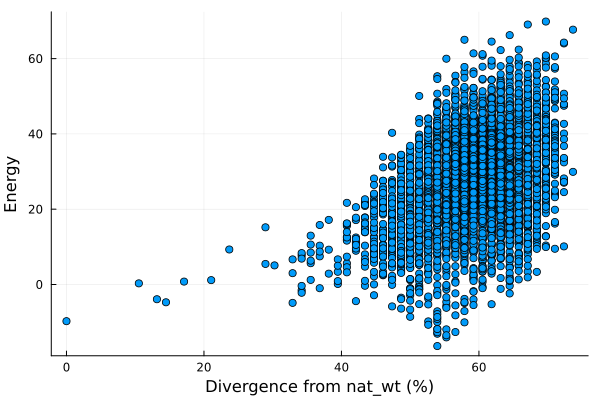

In [31]:
L = 76/100
scatter(d ./L, e, label = "", xlabel = "Divergence from nat_wt (%)",
ylabel = "Energy")